### Spark HW2 Moive Recommendation
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [8]:
ratings.show(5)

+------+-------+------+----------+
userId|movieId|rating| timestamp|
+------+-------+------+----------+
 1| 307| 3.5|1256677221|
 1| 481| 3.5|1256677456|
 1| 1091| 1.5|1256677471|
 1| 1257| 4.5|1256677460|
 1| 1449| 4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows

In [9]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1

In [10]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

10155 out of 53889 movies are rated by only one user

## Part 2: Spark SQL and OLAP

### Q1: The number of Users

In [13]:
q1_result = ratings.select('userId').distinct().count()
print('Number of users is {}.'.format(q1_result))

Number of users is 283228.

### Q2: The number of Movies

In [15]:
q2_result = movies.select('movieId').distinct().count()
print('The number of movies is {}.'.format(q2_result))

The number of movies is 58098.

### Q3:  How many movies are rated by users? List movies not rated before

In [17]:
q3_result_1 = ratings.select('movieId').distinct().count()
print('The number of movies have been rated is {}.'.format(q3_result_1))

The number of movies have been rated is 53889.

In [18]:
movies.createOrReplaceTempView('movies')
ratings.createOrReplaceTempView('ratings')

q3_result_2 = spark.sql("SELECT movieId, title FROM movies WHERE movieId NOT IN (SELECT DISTINCT movieId FROM ratings)")
display(q3_result_2)

movieId,title
25817,Break of Hearts (1935)
26361,Baby Blue Marine (1976)
27153,Can't Be Heaven (Forever Together) (2000)
27433,Bark! (2002)
31945,Always a Bridesmaid (2000)
52696,"Thousand and One Nights, A (1001 Nights) (1945)"
58209,Alex in Wonder (Sex and a Girl) (2001)
60234,"Shock, The (1923)"
69565,Bling: A Planet Rock (2007)
69834,Agency (1980)


### Q4: List Movie Genres

In [20]:
# Data Frame based
display(movies.select('genres').where(col('genres').contains('(no genres listed)') == False)).distinct().orderBy("genres", ascending=False)

genres
Adventure|Animation|Children|Comedy|Fantasy
Adventure|Children|Fantasy
Comedy|Romance
Comedy|Drama|Romance
Comedy
Action|Crime|Thriller
Comedy|Romance
Adventure|Children
Action
Action|Adventure|Thriller


In [21]:
# RDD function
genres = set(movies.select('genres').where(col('genres').contains('(no genres listed)') == False).distinct().rdd.flatMap(lambda x: x).flatMap(lambda x: x.split('|')).collect())
print(genres)

{'Mystery', 'Action', 'Musical', 'Horror', 'Animation', 'IMAX', 'Fantasy', 'Thriller', 'Western', 'Documentary', 'Comedy', 'War', 'Sci-Fi', 'Children', 'Adventure', 'Romance', 'Drama', 'Crime', 'Film-Noir'}

### Q5: Movie for Each Category

In [23]:
d = {}
for genre in genres:
  d[genre] = movies.where(col('genres').contains(genre)).select('title')

In [24]:
d['Animation'].show()

+--------------------+
 title|
+--------------------+
 Toy Story (1995)|
 Balto (1995)|
 Pocahontas (1995)|
Goofy Movie, A (1...|
Gumby: The Movie ...|
Swan Princess, Th...|
Lion King, The (1...|
Secret Adventures...|
Nightmare Before ...|
Pagemaster, The (...|
 Aladdin (1992)|
Snow White and th...|
Beauty and the Be...|
 Pinocchio (1940)|
 Heavy Metal (1981)|
Aristocats, The (...|
All Dogs Go to He...|
James and the Gia...|
 Space Jam (1996)|
Oliver & Company ...|
+--------------------+
only showing top 20 rows

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

In [26]:
from pyspark.mllib.recommendation import ALS

In [27]:
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [28]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [29]:
# check three rows
rating_data.take(3)

Out[ 9 ]: [('1', '307', '3.5'), ('1', '481', '3.5'), ('1', '1091', '1.5')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [31]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)

In [32]:
train.cache()

Out[ 11 ]: PythonRDD[35] at RDD at PythonRDD.scala:56

In [33]:
validation.cache()

Out[ 12 ]: PythonRDD[36] at RDD at PythonRDD.scala:56

In [34]:
test.cache()

Out[ 13 ]: PythonRDD[37] at RDD at PythonRDD.scala:56

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [36]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # the approach to train ALS model
            model = ALS.train(train_data, rank = rank, iterations= num_iters, lambda_= reg)
            # make prediction
            predict = model.predictAll(validation_data.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
            # get the rating result
            rating = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predict)
            # get the RMSE
            error = np.sqrt(rating.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [37]:
num_iterations = 10
ranks = [10, 12, 14]
reg_params = [0.05, 0.1, 0.2]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 latent factors and regularization = 0.05: validation RMSE is 0.8180858432978108
10 latent factors and regularization = 0.1: validation RMSE is 0.819988553797737
10 latent factors and regularization = 0.2: validation RMSE is 0.8651830137075901
12 latent factors and regularization = 0.05: validation RMSE is 0.817667024129119
12 latent factors and regularization = 0.1: validation RMSE is 0.818052061282604
12 latent factors and regularization = 0.2: validation RMSE is 0.8653082055683466
14 latent factors and regularization = 0.05: validation RMSE is 0.8163131201485558
14 latent factors and regularization = 0.1: validation RMSE is 0.8179016504272068
14 latent factors and regularization = 0.2: validation RMSE is 0.8653475957221882

The best model has 14 latent factors and regularization = 0.05
Total Runtime: 2909.51 seconds

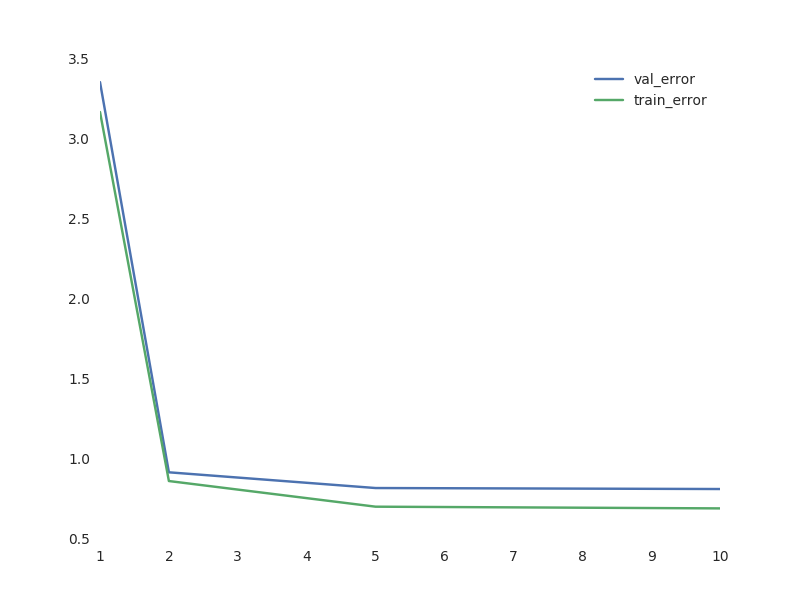

In [38]:
iter_array = [1, 2, 5, 10]
# function to plot the learning curve 
def plot_learning_curve(iter_array, train_data, validation_data, reg, rank):
  val_err = []
  train_err = []
  for iter in iter_array:
    model = ALS().train(train_data, rank = rank, iterations = iter, lambda_ = reg)
    # make prediction
    predict_val = model.predictAll(validation_data.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
    predict_train = model.predictAll(train_data.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
    # get the rating result
    rating_val = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predict_val)
    rating_train = train_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predict_train)
    # get the RMSE
    error_val = np.sqrt(rating_val.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
    error_train = np.sqrt(rating_train.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
    val_err.append(error_val)
    train_err.append(error_train)
  plt.figure(figsize = (8, 6))
  plt.plot(iter_array, val_err, label = 'val_error')
  plt.plot(iter_array, train_err, label = 'train_error')
  plt.legend()
  display()
  
plot_learning_curve(iter_array, train, validation, 0.05, 14)

### Model testing on the test data
And finally, write code to make a prediction and check the testing error.

In [40]:
model = ALS().train(train, rank = 8, iterations = 14, lambda_ = 0.05)
predict_test = model.predictAll(test.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0],x[1]),x[2]))
rating_test = test.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predict_test)
error_test = np.sqrt(rating_test.map(lambda x: (x[1][0] - x[1][1]) ** 2).mean())
print("The rmse of test data on best model is {}.".format(error_test))

The rmse of test data on best model is 0.8162893030621526.

### For each user, recommend movies

In [42]:
movie_feature = model.productFeatures()
movie_feature_res = spark.createDataFrame(movie_feature, ['movieId', 'feature'])

user_feature = model.userFeatures()
user_feature_res = spark.createDataFrame(user_feature, ['userId', 'feature'])

In [43]:
movie_feature_res.show()

+-------+--------------------+
movieId| feature|
+-------+--------------------+
 8|[0.22596226632595...|
 16|[0.78140676021575...|
 24|[0.60047900676727...|
 32|[0.50578874349594...|
 40|[-0.4527341127395...|
 48|[0.04208697378635...|
 56|[0.15260855853557...|
 64|[0.42013049125671...|
 72|[-0.1778321564197...|
 80|[-0.5398471355438...|
 88|[0.99798697233200...|
 96|[-0.0424972958862...|
 104|[0.59151417016983...|
 112|[0.13182307779788...|
 120|[0.39903762936592...|
 128|[0.51212608814239...|
 136|[-0.6848206520080...|
 144|[0.09278756380081...|
 152|[0.49082419276237...|
 160|[0.80556720495224...|
+-------+--------------------+
only showing top 20 rows

In [44]:
user_feature_res.show()

+------+--------------------+
userId| feature|
+------+--------------------+
 8|[-0.3141858279705...|
 16|[0.07932534068822...|
 24|[0.28419101238250...|
 32|[0.56369340419769...|
 40|[1.75554549694061...|
 48|[0.66890400648117...|
 56|[0.66390377283096...|
 64|[0.49497380852699...|
 72|[0.75950092077255...|
 80|[0.98126143217086...|
 88|[0.73955643177032...|
 96|[0.89034777879714...|
 104|[1.41541433334350...|
 112|[0.08504784107208...|
 120|[0.10988394916057...|
 128|[-0.0198610555380...|
 136|[0.26282060146331...|
 144|[-0.2846747636795...|
 152|[0.73523473739624...|
 160|[0.25996553897857...|
+------+--------------------+
only showing top 20 rows

In [45]:
def movieName(movieId):
  name = movies.where(col('movieId').isin(movieId)).select('title').toPandas()['title'].tolist()
  return list(zip(movieId,name))

def recommendedMovie(userId, num):
  recommendedMovies = pd.DataFrame(model.recommendProducts(user = userId, num = num))['product'].tolist()
  return movieName(recommendedMovies)
  
def ratedMovie(userId, num):
  ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
  ratedMovies_rating = ratings.where(col('userId') == userId).select('movieId','rating').orderBy('rating',ascending = False).limit(num).toPandas()
  ratedMovies = ratedMovies_rating['movieId'].tolist()
  ratings = ratedMovies_rating['rating'].tolist()
  return list(zip(movieName(ratedMovies), ratings))

def similarity(movieId_1, movieId_2, userId):
  movieFeatures = movie_feature_res.where(col('movieId').isin(movieId_1, movieId_2)).select('feature').collect()
  movie_top_1 = np.array(movie_feature_res[0][0])
  movie_top_2 = np.array(movie_feature_res[1][0])
  user = np.array(user_feature_res.where(col('userId') == userId).select('feature').collect()[0][0])
  movie_sim = np.dot(movie_top_1, movie_top_2)
  user_movie_1 = np.dot(movie_top_1, user)
  user_movie_2 = np.dot(movie_top_2, user)
  print('Movie similarity between top 2 movies is {}.'.format(str(movie_sim)))
  print('Similarity between movie 1 and user is {}.'.format(str(user_movie_1)))
  print('Similarity between movie 2 and user is {}.'.format(str(user_movie_2)))

In [46]:
userId = 328
num = 5
print('The user like the following movies. \n')
print(ratedMovie(userId, num))

The user like the following movies. 

[(('30707', 'Million Dollar Baby (2004)'), '2.5')]

In [47]:
print("The folling movies are recommended to this user.")
print(recommendedMovie(userId, num))

The folling movies are recommended to this user.
[(74159, 'Ethan Mao (2004)'), (183845, 'Heidi (2015)'), (183947, 'Cosmos: A Spacetime Odissey'), (180129, 'A Fat Wreck (2016)'), (182723, 'NOFX Backstage Passport 2')]

In [48]:
movieId_1 = 1235
movieId_2 = 4
similarity(movieId_1, movieId_2, userId)

Movie similarity between top 2 movies is Column<b'(movieId[0] * feature[0])'>.
Similarity between movie 1 and user is [Column<b'(movieId[0] * 0.21231649816036224)'>
 Column<b'(movieId[0] * -1.0226976871490479)'>
 Column<b'(movieId[0] * 0.2893986105918884)'>
 Column<b'(movieId[0] * -0.3582662343978882)'>
 Column<b'(movieId[0] * -0.7080104351043701)'>
 Column<b'(movieId[0] * -0.18744643032550812)'>
 Column<b'(movieId[0] * 0.10443216562271118)'>
 Column<b'(movieId[0] * 0.2172616720199585)'>].
Similarity between movie 2 and user is [Column<b'(feature[0] * 0.21231649816036224)'>
 Column<b'(feature[0] * -1.0226976871490479)'>
 Column<b'(feature[0] * 0.2893986105918884)'>
 Column<b'(feature[0] * -0.3582662343978882)'>
 Column<b'(feature[0] * -0.7080104351043701)'>
 Column<b'(feature[0] * -0.18744643032550812)'>
 Column<b'(feature[0] * 0.10443216562271118)'>
 Column<b'(feature[0] * 0.2172616720199585)'>].